## Loading Libraries

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time


from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import  accuracy_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score

## Data Loading

In [2]:
sms_spam_df = pd.read_csv('archive/spam.csv', encoding='latin1')

In [3]:
sms_spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
sms_spam_df.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)

In [5]:
sms_spam_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA

### 1. Handling Null Values

In [6]:
# let's see how many null values we have
sms_spam_df.isnull().sum()

v1    0
v2    0
dtype: int64

In [7]:
''' No null values in either columms '''

' No null values in either columms '

### 2. Handling Duplicate Values

In [8]:
# check for duplicates
sms_spam_df['v2'].duplicated().sum()

403

In [9]:
# drop the irrelevant/ redundant rows of repeated messages to avoid 
# overfitting
sms_spam_df.drop_duplicates(subset=['v2'], inplace=True)

In [10]:
# confirm removal of duplicates
sms_spam_df['v2'].duplicated().sum()

0

In [11]:
display(sms_spam_df)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### 3. Class Distributions

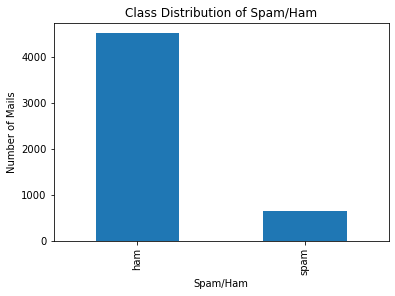

In [12]:
# Create a bar plot of the class distribution
class_counts = sms_spam_df['v1'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Spam/Ham')
plt.xlabel('Spam/Ham')
plt.ylabel('Number of Mails')
plt.show()

## Word Count

In [13]:
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords

In [14]:
# joining all the text in the sentences into a single string
all_text = ' '.join(sms_spam_df['v2'].values)

# remove punctuations
all_text = re.sub(r'http\S+', '', all_text)
all_text = re.sub(r'@\S+', '', all_text)
all_text = re.sub(r'#\S+', '', all_text)

In [15]:
# Split the text into individual words
words = all_text.split()

In [16]:
stopwords = nltk.corpus.stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

def remove_stopwords(x):
    sent = [wordnet_lemmatizer.lemmatize(i, 'v') for i in x.split() if i not in stopwords]
    return ' '.join(sent)

sms_spam_df['v2_corrected'] = sms_spam_df['v2'].apply(lambda x: remove_stopwords(x))
sms_spam_df.head()

,v1,v2,v2_corrected
0,ham,"Go until jurong point, crazy.. Available only ...","Go jurong point, crazy.. Available bugis n gre..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,U dun say early hor... U c already say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","Nah I think go usf, live around though"


## Train test split

In [17]:
labels = sms_spam_df['v1']
labels

0        ham
1        ham
2       spam
3        ham
4        ham
        ... 
5567    spam
5568     ham
5569     ham
5570     ham
5571     ham
Name: v1, Length: 5169, dtype: object

In [18]:
#Encoding the train data
target={'ham':0, 'spam':1}

labels = labels.map(target)
labels

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: v1, Length: 5169, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(sms_spam_df, labels, test_size=0.2 , random_state=42)

## Text Vectorization

In [20]:
# Instantiate countvectorizer
countvec = CountVectorizer(ngram_range=(1,1))
countvec1 = CountVectorizer(ngram_range=(1,1))

# Vectorization of the data
count_train_data = countvec.fit_transform(X_train.v2_corrected)
count_test_data = countvec.transform(X_test.v2_corrected)

count_training_data = countvec1.fit_transform(sms_spam_df.v2_corrected)
# count_validation_data = countvec1.transform(validation_df.no_stopwords)


X_train= pd.DataFrame(count_train_data.toarray(), columns=countvec.get_feature_names())
X_test  = pd.DataFrame(count_test_data.toarray(), columns=countvec.get_feature_names())

train_data= pd.DataFrame(count_training_data.toarray(), columns=countvec1.get_feature_names())
# validation_data= pd.DataFrame(count_validation_data.toarray(), columns=countvec1.get_feature_names())

X_train.head(3)

C:\Users\GM\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\GM\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\GM\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ó_,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Modeling

In [21]:
#Models to be tested
models = { 'Model' : ['Baseline Logistic Regression Model', 'Baseline Bernoulli Naive Bayes', 'Baseline Random Forest Classifier',\
                      'Baseline Adaboost Classifier', 'Baseline Gradient Boost', 'baseline XGBoost Classifier'],
          'Train Accuracy Score(%)': [0, 0, 0, 0, 0, 0],
          'Test Accuracy Score(%)': [0, 0, 0, 0, 0, 0],
          'Train Log_loss': [0, 0, 0, 0, 0, 0],
          'Test Log_loss': [0, 0, 0, 0, 0, 0],
          'Test AUC': [0, 0, 0, 0, 0, 0]
         }
          

#Dataframe holding the model names and accuracy score and log_loss score
df_model_results = pd.DataFrame(models, columns=['Model','Train Accuracy Score(%)', 'Test Accuracy Score(%)', 'Train Log_loss', 'Test Log_loss', 'Test AUC'])


#Function to fill the dataframe holding model names and accuracy score

def model_results(model_type, y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob):
  index_val = df_model_results[df_model_results['Model']==model_type].index

  df_model_results.loc[index_val, 'Train Accuracy Score(%)'] = round(accuracy_score(y_train, y_train_pred), 2)*100
  df_model_results.loc[index_val, 'Test Accuracy Score(%)'] = round(accuracy_score(y_test, y_test_pred), 2)*100
  df_model_results.loc[index_val, 'Train Log_loss'] = log_loss(y_train, y_train_pred_prob, labels=[0,1])
  df_model_results.loc[index_val, 'Test Log_loss'] = log_loss(y_test, y_test_pred_prob, labels=[0,1])
  df_model_results.loc[index_val, 'Test AUC'] = round(roc_auc_score(y_test, y_test_pred), 2)

  return df_model_results

In [22]:
# Function to run all the baseline models:
def baseline_models(model, model_name):
    model.fit(X_train, y_train)

    y_test_pred_prob = model.predict_proba(X_test)
    y_train_pred_prob = model.predict_proba(X_train)

    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print('*********************************************************************')
    print(classification_report(y_test, y_test_pred ))

    print('*********************************************************************')
    return model_results(model_name,y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)


> <b>i. Logistic Regression</b>

In [23]:
baseline_dt = LogisticRegression()
baseline_models(baseline_dt, 'Baseline Logistic Regression Model')

#Observation:
     # Despite the fact that suicide has more data than drugs, it performs worse than it
     # There is overfitting 

*********************************************************************
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.99      0.86      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss,Test AUC
0,Baseline Logistic Regression Model,100,98,0.022694,0.058422,0.93
1,Baseline Bernoulli Naive Bayes,0,0,0.000000,0.000000,0.00
2,Baseline Random Forest Classifier,0,0,0.000000,0.000000,0.00
3,Baseline Adaboost Classifier,0,0,0.000000,0.000000,0.00
4,Baseline Gradient Boost,0,0,0.000000,0.000000,0.00
5,baseline XGBoost Classifier,0,0,0.000000,0.000000,0.00


In [24]:
y_pred = baseline_dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.9787234042553191

<AxesSubplot:>

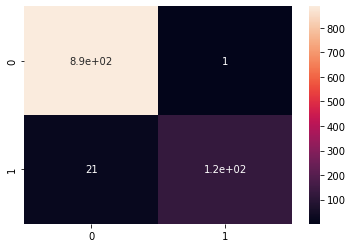

In [25]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

In [26]:
cm

array([[888,   1],
       [ 21, 124]], dtype=int64)

> <b>ii. Bernoulli Naive Bayes</b>

In [27]:
from sklearn.naive_bayes import BernoulliNB
baseline_dt = BernoulliNB()

baseline_models(baseline_dt, 'Baseline Bernoulli Naive Bayes')

*********************************************************************
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       889
           1       1.00      0.80      0.89       145

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.94      1034
weighted avg       0.97      0.97      0.97      1034

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss,Test AUC
0,Baseline Logistic Regression Model,100,98,0.022694,0.058422,0.93
1,Baseline Bernoulli Naive Bayes,99,97,0.114786,0.288280,0.90
2,Baseline Random Forest Classifier,0,0,0.000000,0.000000,0.00
3,Baseline Adaboost Classifier,0,0,0.000000,0.000000,0.00
4,Baseline Gradient Boost,0,0,0.000000,0.000000,0.00
5,baseline XGBoost Classifier,0,0,0.000000,0.000000,0.00


In [28]:
y_pred = baseline_dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.971953578336557

<AxesSubplot:>

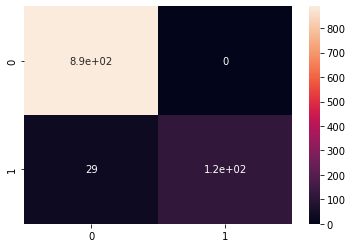

In [29]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

In [30]:
cm

array([[889,   0],
       [ 29, 116]], dtype=int64)

> <b>iii. Random Forest Classifier</b>

In [31]:
baseline_dt = RandomForestClassifier(n_estimators=100, random_state=42)

baseline_models(baseline_dt, 'Baseline Random Forest Classifier')

*********************************************************************
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       889
           1       0.99      0.81      0.89       145

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.94      1034
weighted avg       0.97      0.97      0.97      1034

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss,Test AUC
0,Baseline Logistic Regression Model,100,98,0.022694,0.058422,0.93
1,Baseline Bernoulli Naive Bayes,99,97,0.114786,0.288280,0.90
2,Baseline Random Forest Classifier,100,97,0.021229,0.138666,0.90
3,Baseline Adaboost Classifier,0,0,0.000000,0.000000,0.00
4,Baseline Gradient Boost,0,0,0.000000,0.000000,0.00
5,baseline XGBoost Classifier,0,0,0.000000,0.000000,0.00


In [32]:
y_pred = baseline_dt.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.971953578336557

<AxesSubplot:>

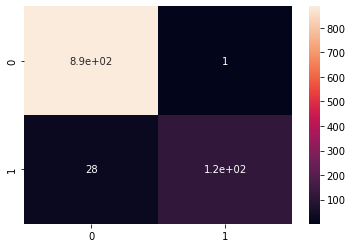

In [33]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

In [34]:
cm

array([[888,   1],
       [ 28, 117]], dtype=int64)

> <b>iv. Adaboost Classifier</b>

In [35]:
baseline_adaboost = AdaBoostClassifier(random_state=0)

baseline_models(baseline_adaboost, 'Baseline Adaboost Classifier')

*********************************************************************
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.97      0.86      0.91       145

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss,Test AUC
0,Baseline Logistic Regression Model,100,98,0.022694,0.058422,0.93
1,Baseline Bernoulli Naive Bayes,99,97,0.114786,0.288280,0.90
2,Baseline Random Forest Classifier,100,97,0.021229,0.138666,0.90
3,Baseline Adaboost Classifier,98,98,0.611125,0.615529,0.93
4,Baseline Gradient Boost,0,0,0.000000,0.000000,0.00
5,baseline XGBoost Classifier,0,0,0.000000,0.000000,0.00


In [36]:
y_pred = baseline_adaboost.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.9758220502901354

<AxesSubplot:>

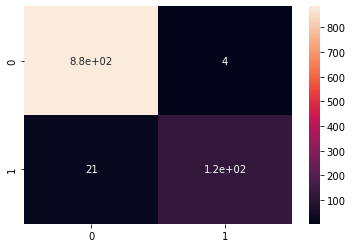

In [37]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

> <b>v. Gradient Boost Classifier</b>

In [38]:
baseline_gradientboost = GradientBoostingClassifier(random_state=0)

baseline_models(baseline_gradientboost, 'Baseline Gradient Boost')

*********************************************************************
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       889
           1       0.98      0.80      0.88       145

    accuracy                           0.97      1034
   macro avg       0.98      0.90      0.93      1034
weighted avg       0.97      0.97      0.97      1034

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss,Test AUC
0,Baseline Logistic Regression Model,100,98,0.022694,0.058422,0.93
1,Baseline Bernoulli Naive Bayes,99,97,0.114786,0.288280,0.90
2,Baseline Random Forest Classifier,100,97,0.021229,0.138666,0.90
3,Baseline Adaboost Classifier,98,98,0.611125,0.615529,0.93
4,Baseline Gradient Boost,98,97,0.072432,0.105339,0.90
5,baseline XGBoost Classifier,0,0,0.000000,0.000000,0.00


In [39]:
y_pred = baseline_gradientboost.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.9700193423597679

<AxesSubplot:>

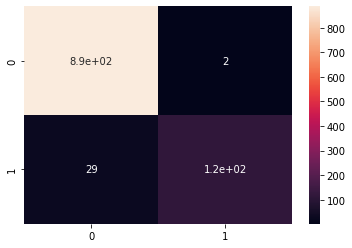

In [40]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

> <b>vi. XGBoost Classifier</b>

In [41]:
xgboost_classifier = XGBClassifier()

baseline_models(xgboost_classifier, 'baseline XGBoost Classifier')

*********************************************************************
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       889
           1       0.93      0.88      0.90       145

    accuracy                           0.97      1034
   macro avg       0.95      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034

*********************************************************************


,Model,Train Accuracy Score(%),Test Accuracy Score(%),Train Log_loss,Test Log_loss,Test AUC
0,Baseline Logistic Regression Model,100,98,0.022694,0.058422,0.93
1,Baseline Bernoulli Naive Bayes,99,97,0.114786,0.288280,0.90
2,Baseline Random Forest Classifier,100,97,0.021229,0.138666,0.90
3,Baseline Adaboost Classifier,98,98,0.611125,0.615529,0.93
4,Baseline Gradient Boost,98,97,0.072432,0.105339,0.90
5,baseline XGBoost Classifier,99,97,0.041744,0.065445,0.94


In [42]:
y_pred = xgboost_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
acc

0.9738878143133463

<AxesSubplot:>

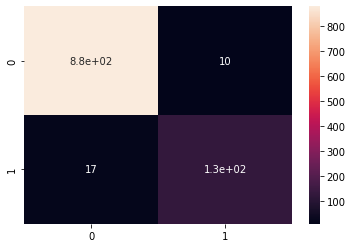

In [43]:
# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True)

In [ ]:
# tuned model
Tuned_xgboost = XGBClassifier()
param_grid = {'learning_rate': [0.1,0.2],
               'max_depth': [4, 6, 10],
               'n_estimators':[200, 300, 400]}


xgbclassifier_grid_search = GridSearchCV(Tuned_xgboost, param_grid, scoring='accuracy', cv=3, n_jobs=1)

xgbclassifier_grid_search.fit(X_train, y_train)

y_test_pred_prob = xgbclassifier_grid_search.predict_proba(X_test)
y_train_pred_prob = xgbclassifier_grid_search.predict_proba(X_train)

y_test_pred = xgbclassifier_grid_search.predict(X_test)
y_train_pred = xgbclassifier_grid_search.predict(X_train)

print('*********************************************************************')
print(classification_report(y_test, y_test_pred ))

print('*********************************************************************')
model_results('XGBoost Classifier-Grid Search',y_train, y_train_pred, y_train_pred_prob, y_test, y_test_pred, y_test_pred_prob)

In [ ]:
# another attempt
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)